# High Resolution Conflict Forecasting with Spatial Convolutions and Long Short-Term Memory

## Replication Archive

[Benjamin J. Radford](https://www.benradford.com)    
Assistant Professor  
UNC Charlotte  
bradfor7@uncc.edu  

This file replicates the following tables and figures:

* Table 2 (columns 1-4)
* Figure 4
* Figure 5
* Figure 6

## Imports and seeds

In [1]:
#### import sys
import os
import gc
import logging

import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

from itertools import product
from math import isnan

import views
from views import Period, Model, Downsampling
from views.utils.data import assign_into_df
from views.apps.transforms import lib as translib
from views.apps.evaluation import lib as evallib, feature_importance as fi
from views.apps.model import api
from views.apps.extras import extras

import keras
from keras.models import Model
from keras.layers import Input, ConvLSTM2D, Activation, Conv3D, BatchNormalization, Dropout, Bidirectional, GaussianNoise
from keras import optimizers

import tensorflow as tf

import random
import geoplot as gplt
import contextily as ctx

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

from numpy.random import seed
seed(1234)
tf.random.set_seed(1234)

pgid_groupa = [149426,149427,149428,149429,149430, 148706,148707,148708,148709,148710, 147986,
147987,147988,147989,147990, 147266,147267,147268,147269,147270, 146546,146547,146548,
146549,146550]

pgid_groupb = [114918,114919,114920,114921,114922, 114198,114199,114200,114201,114202, 113478,
113479,113480,113481,113482, 112758,112759,112760,112761,112762, 112038,112039,112040,
112041,112042]

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Load data

In [2]:
# Do you wish to fetch the latest public data? If so, change False to True and run this cell
# Cells below will fail if this is not run if you haven't imported data yourself yet.
redownload_data = False

if redownload_data:
    path_zip = views.apps.data.public.fetch_latest_zip_from_website(path_dir_destination=views.DIR_SCRATCH)
    views.apps.data.public.import_tables_and_geoms(tables=views.TABLES, geometries=views.GEOMETRIES, path_zip=path_zip)

dataset = views.DATASETS["pgm_africa_imp_0"]
df = dataset.gdf
df.reset_index(inplace=True)

update = pd.read_csv("../data/pgm.csv")
df = pd.merge(df[["geom","pg_id","month_id"]], update, on=["pg_id","month_id"])

## Prepare data

In [3]:
df = df.loc[(df["year"]<2021) & (df["year"]>1989)]
df = df.loc[(df["year"]<2020) | (df["month"]<9)]
df["coordx"] = df["geom"].apply(lambda x: x.centroid.x)
df["coordy"] = df["geom"].apply(lambda y: y.centroid.y)
df["col_idx"] = [int(a) for a in list((df["coordx"] - df["coordx"].min())*2)]
df["row_idx"] = [int(a) for a in list((df["coordy"] - df["coordy"].min())*2)]
df["year_idx"] = [int(a) for a in list((df["year"] - df["year"].min()))]
df["month_idx"] = [int(a) for a in list((df["month"] - df["month"].min()))]
df["year_month_idx"] = [int(a) for a in list((df["month_id"] - df["month_id"].min()))]

# df.drop("geom", inplace=True, axis=1) 


##
## Make Lags
##
df1 = df[["year_month_idx","pg_id","ln_ged_best_sb"]].copy()
df2 = df[["year_month_idx","pg_id","ln_ged_best_sb"]].copy()
df3 = df[["year_month_idx","pg_id","ln_ged_best_sb"]].copy()
df4 = df[["year_month_idx","pg_id","ln_ged_best_sb"]].copy()
df5 = df[["year_month_idx","pg_id","ln_ged_best_sb"]].copy()
df6 = df[["year_month_idx","pg_id","ln_ged_best_sb"]].copy()
df7 = df[["year_month_idx","pg_id","ln_ged_best_sb"]].copy()

df1["year_month_idx"] = df1["year_month_idx"]+1
df2["year_month_idx"] = df2["year_month_idx"]+2
df3["year_month_idx"] = df3["year_month_idx"]+3
df4["year_month_idx"] = df4["year_month_idx"]+4
df5["year_month_idx"] = df5["year_month_idx"]+5
df6["year_month_idx"] = df6["year_month_idx"]+6
df7["year_month_idx"] = df7["year_month_idx"]+7

df1.columns = ["year_month_idx","pg_id","ln_ged_best_sb_l1"]
df2.columns = ["year_month_idx","pg_id","ln_ged_best_sb_l2"]
df3.columns = ["year_month_idx","pg_id","ln_ged_best_sb_l3"]
df4.columns = ["year_month_idx","pg_id","ln_ged_best_sb_l4"]
df5.columns = ["year_month_idx","pg_id","ln_ged_best_sb_l5"]
df6.columns = ["year_month_idx","pg_id","ln_ged_best_sb_l6"]
df7.columns = ["year_month_idx","pg_id","ln_ged_best_sb_l7"]

df = pd.merge(df,df1,how="left",on=["year_month_idx","pg_id"])
df = pd.merge(df,df2,how="left",on=["year_month_idx","pg_id"])
df = pd.merge(df,df3,how="left",on=["year_month_idx","pg_id"])
df = pd.merge(df,df4,how="left",on=["year_month_idx","pg_id"])
df = pd.merge(df,df5,how="left",on=["year_month_idx","pg_id"])
df = pd.merge(df,df6,how="left",on=["year_month_idx","pg_id"])
df = pd.merge(df,df7,how="left",on=["year_month_idx","pg_id"])

df["delta_1"] = df["ln_ged_best_sb"] - df["ln_ged_best_sb_l1"]
df["delta_2"] = df["ln_ged_best_sb"] - df["ln_ged_best_sb_l2"]
df["delta_3"] = df["ln_ged_best_sb"] - df["ln_ged_best_sb_l3"]
df["delta_4"] = df["ln_ged_best_sb"] - df["ln_ged_best_sb_l4"]
df["delta_5"] = df["ln_ged_best_sb"] - df["ln_ged_best_sb_l5"]
df["delta_6"] = df["ln_ged_best_sb"] - df["ln_ged_best_sb_l6"]
df["delta_7"] = df["ln_ged_best_sb"] - df["ln_ged_best_sb_l7"]

del df1
del df2
del df3
del df4
del df5
del df6
del df7

gc.collect()

pg_col_row = df[["pg_id","col_idx","row_idx","geom"]].drop_duplicates()
pg_col_row = pd.concat([pg_col_row] * 7)
pg_col_row["month_id"] = ([489]*10677) + ([490]*10677) + ([491]*10677) + ([492]*10677) + ([493]*10677) + ([494]*10677) + ([495]*10677)
pg_col_row["year_month_idx"] = pg_col_row["month_id"] - 121

print(pg_col_row.shape)
df = pd.concat([df,pg_col_row])
print(df.shape)

df.reset_index(inplace=True)

(74739, 6)
(4003875, 289)


## Load appropriate prediction sets

In [4]:
set1 = pd.read_csv("../data/competition_model/forecasts/updated_ViEWSpred_competition_radford_set1.csv")
set2 = pd.read_csv("../data/competition_model/forecasts/updated_ViEWSpred_competition_radford_set2.csv")
set3 = pd.read_csv("../data/competition_model/forecasts/updated_ViEWSpred_competition_radford_set3.csv")

forecasts = pd.concat([set3,set2,set1])

df = pd.merge(df, forecasts, how="outer", left_on=["pg_id","month_id"], right_on=["pg_id","month_id"])

## Table 2: Out-of-sample predictive performance on validation and test sets

Columns *Validation* and *Test (17-19)*

In [5]:
def get_row_metrics(actual,pred,rowname):
    mse = np.mean(np.power(actual - pred,2))
    tadda = evallib.tadda_score(actual, pred)
    return f"{rowname} & {mse:.6f} & {tadda:.6f} \\\\"

print("\hline \n \\\\ Steps & MSE & TADDA \\\\ \n \hline \\\\")
# print(get_row_metrics(df.loc[(df["year"]>2013) & (df["year"]<2017)]["delta_1"], 
#                       df.loc[(df["year"]>2013) & (df["year"]<2017)]["Radford_clstm_s1"],
#                       "$s=1$"))
print(get_row_metrics(df.loc[(df["year"]>2013) & (df["year"]<2017)]["delta_2"], 
                      df.loc[(df["year"]>2013) & (df["year"]<2017)]["Radford_clstm_s2"],
                      "$s=2$"))
print(get_row_metrics(df.loc[(df["year"]>2013) & (df["year"]<2017)]["delta_3"], 
                      df.loc[(df["year"]>2013) & (df["year"]<2017)]["Radford_clstm_s3"],
                      "$s=3$"))
print(get_row_metrics(df.loc[(df["year"]>2013) & (df["year"]<2017)]["delta_4"], 
                      df.loc[(df["year"]>2013) & (df["year"]<2017)]["Radford_clstm_s4"],
                      "$s=4$"))
print(get_row_metrics(df.loc[(df["year"]>2013) & (df["year"]<2017)]["delta_5"], 
                      df.loc[(df["year"]>2013) & (df["year"]<2017)]["Radford_clstm_s5"],
                      "$s=5$"))
print(get_row_metrics(df.loc[(df["year"]>2013) & (df["year"]<2017)]["delta_6"], 
                      df.loc[(df["year"]>2013) & (df["year"]<2017)]["Radford_clstm_s6"],
                      "$s=6$"))
print(get_row_metrics(df.loc[(df["year"]>2013) & (df["year"]<2017)]["delta_7"], 
                      df.loc[(df["year"]>2013) & (df["year"]<2017)]["Radford_clstm_s7"],
                      "$s=7$"))
print("\hline")


print("\hline \n \\\\ Steps & MSE & TADDA \\\\ \n \hline \\\\")
# print(get_row_metrics(df.loc[(df["year"]>2016) & (df["year"]<2020)]["delta_1"], 
#                       df.loc[(df["year"]>2016) & (df["year"]<2020)]["Radford_clstm_s1"],
#                       "$s=1$"))
print(get_row_metrics(df.loc[(df["year"]>2016) & (df["year"]<2020)]["delta_2"], 
                      df.loc[(df["year"]>2016) & (df["year"]<2020)]["Radford_clstm_s2"],
                      "$s=2$"))
print(get_row_metrics(df.loc[(df["year"]>2016) & (df["year"]<2020)]["delta_3"], 
                      df.loc[(df["year"]>2016) & (df["year"]<2020)]["Radford_clstm_s3"],
                      "$s=3$"))
print(get_row_metrics(df.loc[(df["year"]>2016) & (df["year"]<2020)]["delta_4"], 
                      df.loc[(df["year"]>2016) & (df["year"]<2020)]["Radford_clstm_s4"],
                      "$s=4$"))
print(get_row_metrics(df.loc[(df["year"]>2016) & (df["year"]<2020)]["delta_5"], 
                      df.loc[(df["year"]>2016) & (df["year"]<2020)]["Radford_clstm_s5"],
                      "$s=5$"))
print(get_row_metrics(df.loc[(df["year"]>2016) & (df["year"]<2020)]["delta_6"], 
                      df.loc[(df["year"]>2016) & (df["year"]<2020)]["Radford_clstm_s6"],
                      "$s=6$"))
print(get_row_metrics(df.loc[(df["year"]>2016) & (df["year"]<2020)]["delta_7"], 
                      df.loc[(df["year"]>2016) & (df["year"]<2020)]["Radford_clstm_s7"],
                      "$s=7$"))
print("\hline")

\hline 
 \\ Steps & MSE & TADDA \\ 
 \hline \\
$s=2$ & 0.020784 & 0.013735 \\
$s=3$ & 0.020759 & 0.013556 \\
$s=4$ & 0.021189 & 0.014036 \\
$s=5$ & 0.021569 & 0.013954 \\
$s=6$ & 0.021434 & 0.014262 \\
$s=7$ & 0.021692 & 0.014872 \\
\hline
\hline 
 \\ Steps & MSE & TADDA \\ 
 \hline \\
$s=2$ & 0.021841 & 0.016387 \\
$s=3$ & 0.022152 & 0.016240 \\
$s=4$ & 0.022149 & 0.016549 \\
$s=5$ & 0.022731 & 0.016491 \\
$s=6$ & 0.022960 & 0.016893 \\
$s=7$ & 0.022932 & 0.017759 \\
\hline


## Figure 5: Predicted versus observed...

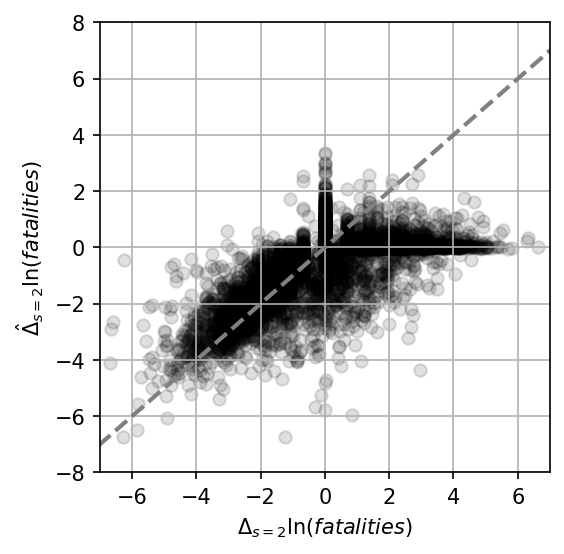

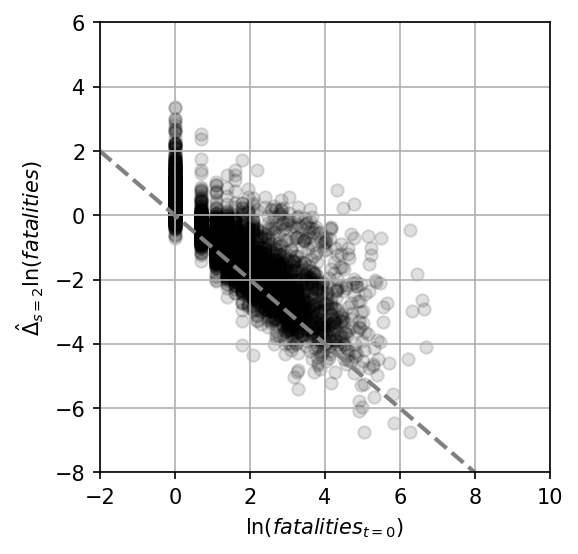

In [6]:
fig=plt.figure(figsize=(3,3),dpi=150)
ax=fig.add_axes([0,0,1,1])
ax.scatter(df["delta_2"],df["Radford_clstm_s2"], color='#00000020')
ax.plot([-100, 100], [-100, 100], color="gray", linestyle='--', linewidth=2)
ax.set_xlabel('$\Delta_{s=2}\ln(fatalities)$')
ax.set_ylabel('$\hat{\Delta}_{s=2}\ln(fatalities)$')
# ax.set_title('Actual Versus Predicted Change')
plt.xlim(-7,7)
plt.ylim(-8,8)
plt.grid(True)
plt.savefig("../figures/actual_vs_predicted.png", bbox_inches='tight')
plt.show()

fig=plt.figure(figsize=(3,3),dpi=150)
ax=fig.add_axes([0,0,1,1])
ax.scatter(df["ln_ged_best_sb_l2"],df["Radford_clstm_s2"], color='#00000020')
ax.plot([-100, 100], [100, -100], color="gray", linestyle='--', linewidth=2)
ax.set_xlabel('$\ln(fatalities_{t=0})$')
ax.set_ylabel('$\hat{\Delta}_{s=2}\ln(fatalities)$')
# ax.set_title('Casualties as a Predictor of Change')
plt.xlim(-2,10)
plt.ylim(-8,6)
plt.grid(True)
plt.savefig("../figures/count_vs_predicted.png", bbox_inches='tight')
plt.show()



## Reproject data for mapping

In [7]:
from pyproj import Proj, transform

df = df.to_crs(epsg=3857)


## Create a new color palette for maps

In [8]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


ncolors = 257
color_array = plt.get_cmap('seismic')(range(ncolors))
color_array[127:129,:] = 1.

# color_array = np.zeros((ncolors, 4))
# color_array[0:int(ncolors/2),2] = 1.
# color_array[int(ncolors/2):,0] = 1.

# change alpha values
color_array[0:int(np.floor(ncolors/2)),-1] = (10-np.logspace(0.0,1.0,int(ncolors/2)))/9
color_array[int(np.ceil(ncolors/2)):,-1] = (10-np.logspace(1.0,0.0,int(ncolors/2)))/9
# color_array[127:130,-1] = 0

# create a colormap object
map_object = matplotlib.colors.LinearSegmentedColormap.from_list(name='bar',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

## Figure 4: Maps

/home/ben/anaconda3/envs/views2/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ben/anaconda3/envs/views2/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/ben/anaconda3/envs/views2/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred i

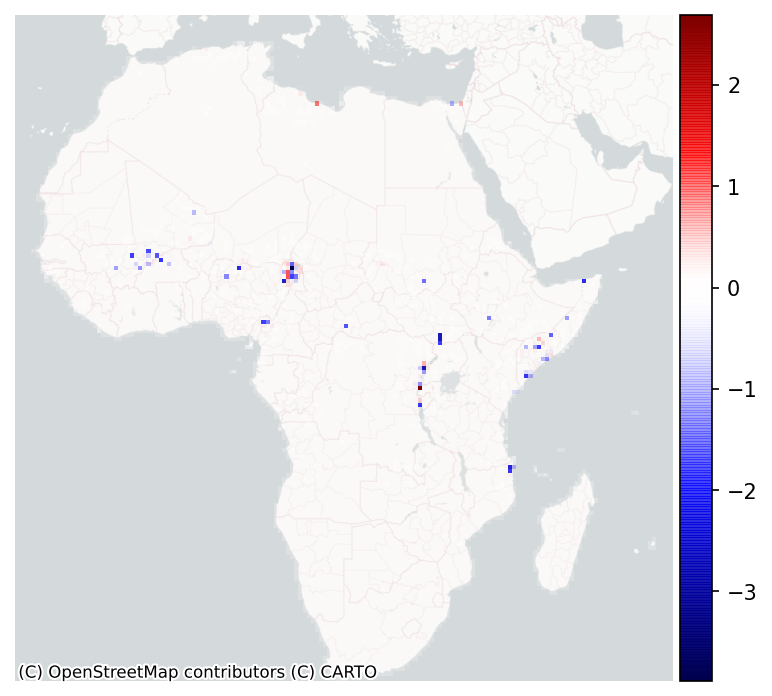

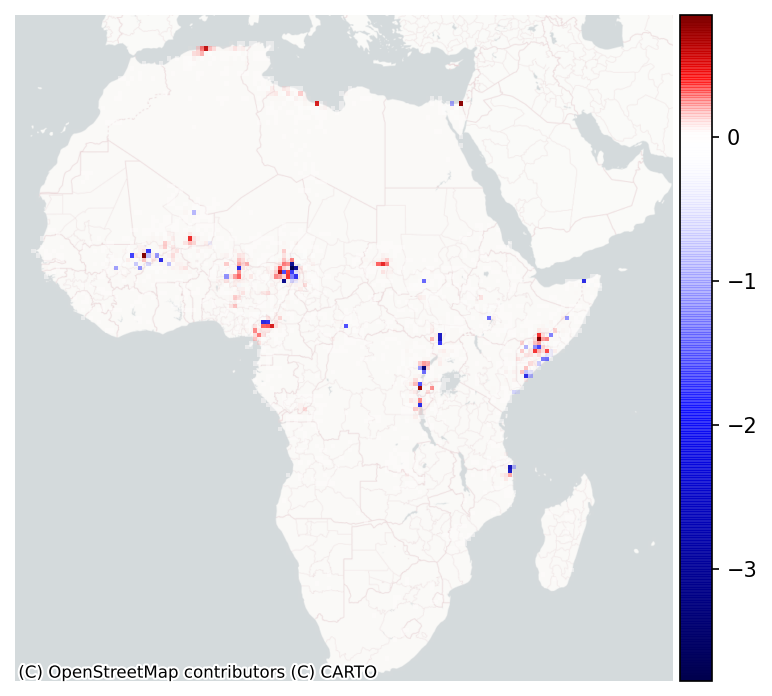

/home/ben/anaconda3/envs/views2/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/ben/anaconda3/envs/views2/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/ben/anaconda3/envs/views2/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred i

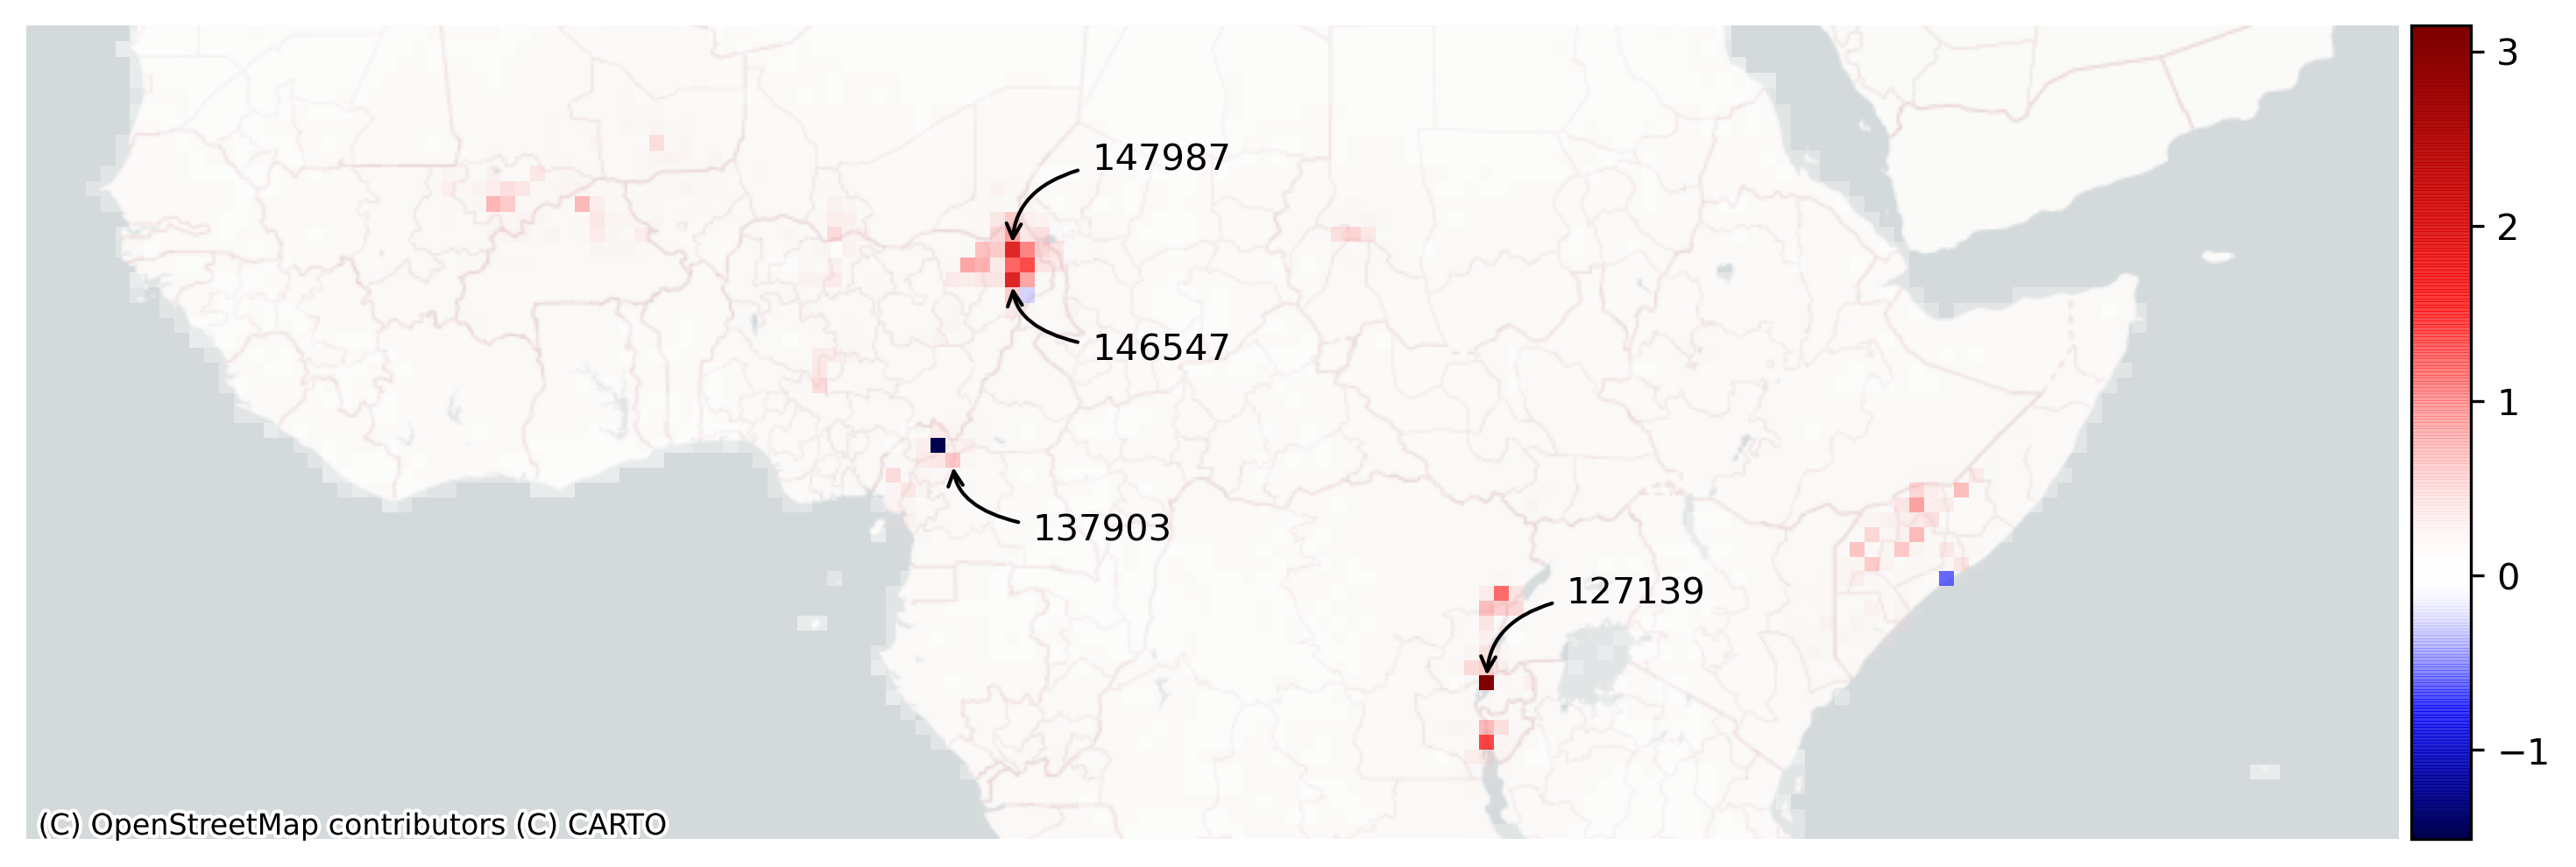

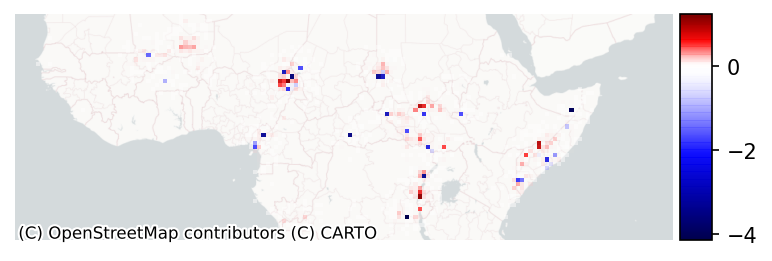

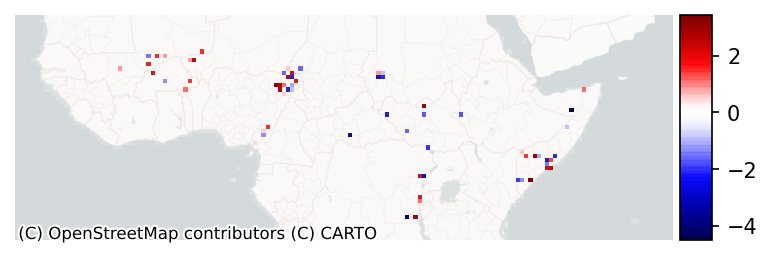

In [9]:
lower_left = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), -20, -35)
upper_right = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 60, 40)

###
### PRED l2
###
shifted_cmap = shiftedColorMap(map_object, 
                               midpoint=1-(df.loc[df["month_id"]==490]["Radford_clstm_s2"].max()/(df.loc[df["month_id"]==490]["Radford_clstm_s2"].max()+np.abs(df.loc[df["month_id"]==490]["Radford_clstm_s2"].min()))), 
                               name='shifted')

# topper = [(np.log(a)/np.log(9))/2+0.5 for a in range(1,10)]
# botter = [1 - a for a in topper]
# botter.reverse()

# colors = [plt.get_cmap('seismic')(a) for a in botter+topper]
# n_bin_ranges = [-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4]
# n_bin = len(n_bin_ranges)-1
# cm = matplotlib.colors.LinearSegmentedColormap.from_list("grays", colors, N=n_bin)
# norm = matplotlib.colors.BoundaryNorm(n_bin_ranges, len(n_bin_ranges))

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=150)
plt.xlim=(lower_left[1], upper_right[1])
plt.ylim=(lower_left[0], upper_right[1])
divider = make_axes_locatable(ax)
ax.axis('off')
ax.axis((lower_left[0],upper_right[0],lower_left[1],upper_right[1]))
ax.set_facecolor((1.,1.,1.))
cax = divider.append_axes("right", size="5%", pad=0.05)

df.loc[df["month_id"]==490].plot(figsize=(10, 10), 
                                         column=df.loc[df["month_id"]==490]["Radford_clstm_s2"], 
                                         edgecolor=None, 
                                         cmap=shifted_cmap,
                                         legend=True,
                                         ax=ax,
                                         cax=cax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, zoom=4)
plt.savefig("../figures/map_predicted_oct.pdf", bbox_inches="tight")
plt.show()

###
### PREDICTED l7
###

shifted_cmap = shiftedColorMap(map_object, 
                               midpoint=1-(df.loc[df["month_id"]==495]["Radford_clstm_s7"].max()/(df.loc[df["month_id"]==495]["Radford_clstm_s7"].max()+np.abs(df.loc[df["month_id"]==495]["Radford_clstm_s7"].min()))), 
                               name='shifted')

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=150)
plt.xlim=(lower_left[1], upper_right[1])
plt.ylim=(lower_left[0], upper_right[1])
divider = make_axes_locatable(ax)
ax.axis('off')
ax.axis((lower_left[0],upper_right[0],lower_left[1],upper_right[1]))
cax = divider.append_axes("right", size="5%", pad=0.05)

df.loc[df["month_id"]==495].plot(figsize=(10, 10), 
                                         column=df.loc[df["month_id"]==495]["Radford_clstm_s7"], 
                                         edgecolor=None, 
                                         cmap=shifted_cmap,
                                         legend=True,
                                         ax=ax,
                                         cax=cax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, zoom=4)
plt.savefig("../figures/map_predicted_mar.pdf", bbox_inches="tight")
plt.show()

###
### PREDICTED MAX
###

lower_left = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), -20, -7)
upper_right = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 60, 20)

subset = df.loc[df["month_id"]>489]
subset["maxpred"] = subset[["Radford_clstm_s2",
                            "Radford_clstm_s3",
                            "Radford_clstm_s4",
                            "Radford_clstm_s5",
                            "Radford_clstm_s6",
                            "Radford_clstm_s7",]].max(axis=1)
subset = subset[["pg_id","maxpred"]].groupby("pg_id").agg("max").reset_index()
subset = df.loc[df["month_id"]==490][["pg_id","geom"]].merge(subset, how="right", left_on="pg_id", right_on="pg_id")

shifted_cmap = shiftedColorMap(map_object, 
                               midpoint=1-(subset["maxpred"].max()/(subset["maxpred"].max()+np.abs(subset["maxpred"].min()))), 
                               name='shifted')

fig, ax = plt.subplots(1, 1, figsize=(12,12), dpi=300)
plt.xlim=(lower_left[1], upper_right[1])
plt.ylim=(lower_left[0], upper_right[1])
divider = make_axes_locatable(ax)
ax.axis('off')
ax.axis((lower_left[0],upper_right[0],lower_left[1],upper_right[1]))
cax = divider.append_axes("right", size="2.5%", pad=0.05)

subset.plot(figsize=(10, 10), 
             column=subset["maxpred"], 
             edgecolor=None, 
             cmap=shifted_cmap,
             legend=True,
             ax=ax,
             cax=cax)
rwanda = df.loc[(df["pg_id"]==127139) & (df["month_id"]==490)]["geom"].centroid
rwanda_x = rwanda.x
rwanda_y = rwanda.y

nigeria = df.loc[(df["pg_id"]==146547) & (df["month_id"]==490)]["geom"].centroid
nigeria_x = nigeria.x
nigeria_y = nigeria.y

nigeria_b = df.loc[(df["pg_id"]==147987) & (df["month_id"]==490)]["geom"].centroid
nigeria_b_x = nigeria_b.x
nigeria_b_y = nigeria_b.y

cameroon = df.loc[(df["pg_id"]==137903) & (df["month_id"]==490)]["geom"].centroid
cameroon_x = cameroon.x
cameroon_y = cameroon.y


ax.annotate("127139", xy=(rwanda_x,rwanda_y), 
            xytext=(rwanda_x+300000, rwanda_y+300000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=90"))

ax.annotate("146547", xy=(nigeria_x,nigeria_y), 
            xytext=(nigeria_x+300000, nigeria_y-300000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate("147987", xy=(nigeria_b_x,nigeria_b_y), 
            xytext=(nigeria_b_x+300000, nigeria_b_y+300000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=90"))

ax.annotate("137903", xy=(cameroon_x,cameroon_y), 
            xytext=(cameroon_x+300000, cameroon_y-300000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, zoom=4)
plt.savefig("../figures/map_predicted_max.pdf", bbox_inches="tight")
plt.show()

###
### PRED DEC 2018 l2
###
shifted_cmap = shiftedColorMap(map_object, 
                               midpoint=1-(df.loc[df["month_id"]==468]["Radford_clstm_s7"].max()/(df.loc[df["month_id"]==468]["Radford_clstm_s7"].max()+np.abs(df.loc[df["month_id"]==468]["Radford_clstm_s7"].min()))), 
                               name='shifted')

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=150)
plt.xlim=(lower_left[1], upper_right[1])
plt.ylim=(lower_left[0], upper_right[1])
divider = make_axes_locatable(ax)
ax.axis('off')
ax.axis((lower_left[0],upper_right[0],lower_left[1],upper_right[1]))
ax.set_facecolor((1.,1.,1.))
cax = divider.append_axes("right", size="5%", pad=0.05)

df.loc[df["month_id"]==490].plot(figsize=(10, 10), 
                                         column=df.loc[df["month_id"]==468]["Radford_clstm_s7"], 
                                         edgecolor=None, 
                                         cmap=shifted_cmap,
                                         legend=True,
                                         ax=ax,
                                         cax=cax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, zoom=4)
plt.savefig("../figures/map_predicted_dec2018.pdf", bbox_inches="tight")
plt.show()

###
### ACTUAL DEC 2018 l2
###
shifted_cmap = shiftedColorMap(map_object, 
                               midpoint=1-(df.loc[df["month_id"]==468]["delta_7"].max()/(df.loc[df["month_id"]==468]["delta_7"].max()+np.abs(df.loc[df["month_id"]==468]["delta_7"].min()))), 
                               name='shifted')

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=150)
plt.xlim=(lower_left[1], upper_right[1])
plt.ylim=(lower_left[0], upper_right[1])
divider = make_axes_locatable(ax)
ax.axis('off')
ax.axis((lower_left[0],upper_right[0],lower_left[1],upper_right[1]))
ax.set_facecolor((1.,1.,1.))
cax = divider.append_axes("right", size="5%", pad=0.05)

df.loc[df["month_id"]==490].plot(figsize=(10, 10), 
                                         column=df.loc[df["month_id"]==468]["delta_7"], 
                                         edgecolor=None, 
                                         cmap=shifted_cmap,
                                         legend=True,
                                         ax=ax,
                                         cax=cax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, zoom=4)
plt.savefig("../figures/map_actual_dec2018.pdf", bbox_inches="tight")
plt.show()


In [10]:
# df[["month_id","month","year"]].drop_duplicates().tail(50)

## Investigation of specific cases

In [11]:
# subset.sort_values(by="maxpred", ascending=False)

In [12]:
# df.loc[(df["month_id"]>489) & (df["pg_id"]==127139)]
# #Rwanda near border with Uganda and DRC

In [13]:
# df.loc[(df["month_id"]>489) & (df["pg_id"]==146547)]
# # Nigeria near Cameroon

In [14]:
# df.loc[(df["month_id"]>489) & (df["pg_id"]==147987)]
# # Nigeria near Cameroon

## Figure 6: Delta ln(fatalities) over time...

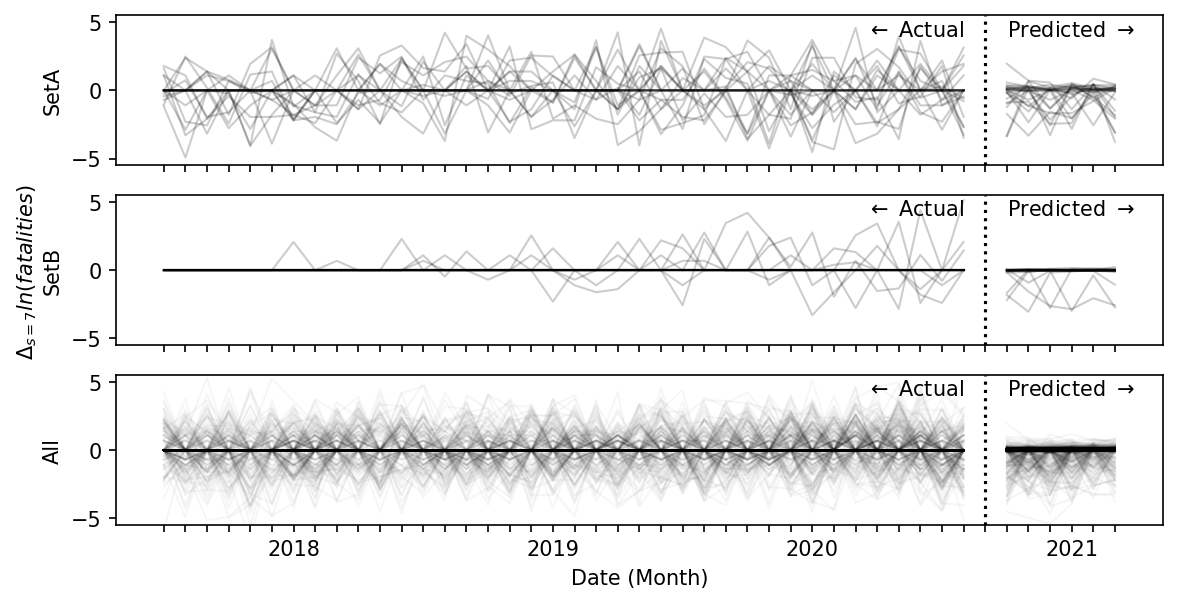

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex='col', figsize=(9,4.5), dpi=150)

for pg_id in pgid_groupa:
    sub = df.loc[(df["pg_id"]==pg_id)]
    ax1.plot( 'month_id', 'delta_7', data=sub.loc[(sub["month_id"] > 450)], color="#00000033", linewidth=1)
    ax1.plot( 'month_id', 'Radford_clstm_s7', data=sub.loc[(sub["month_id"] > 489)], color='#00000033', linewidth=1)

for pg_id in pgid_groupb:
    sub = df.loc[(df["pg_id"]==pg_id)]
    ax2.plot( 'month_id', 'delta_7', data=sub.loc[(sub["month_id"] > 450)], color="#00000033", linewidth=1)
    ax2.plot( 'month_id', 'Radford_clstm_s7', data=sub.loc[(sub["month_id"] > 489)], color='#00000033', linewidth=1)
    
for pg_id in df["pg_id"].unique():
    sub = df.loc[(df["pg_id"]==pg_id)]
    ax3.plot( 'month_id', 'delta_7', data=sub.loc[(sub["month_id"] > 450)], color="#00000009", linewidth=1)
    ax3.plot( 'month_id', 'Radford_clstm_s7', data=sub.loc[(sub["month_id"] > 489)], color='#00000009', linewidth=1)

plt.xticks([457,469,481,493],["2018","2019","2020","2021"])
plt.xticks(list(range(451,496)))

ax1.set_ylim(-5.5,5.5)
ax2.set_ylim(-5.5,5.5)
ax3.set_ylim(-5.5,5.5)

ax1.axvline(x=489, linestyle=":", c='k')
ax2.axvline(x=489, linestyle=":", c='k')
ax3.axvline(x=489, linestyle=":", c='k')
ax1.text(490, 4, r"Predicted $\rightarrow$")
ax1.text(488, 4, r"$\leftarrow$ Actual", horizontalalignment="right")
ax2.text(490, 4, r"Predicted $\rightarrow$")
ax2.text(488, 4, r"$\leftarrow$ Actual", horizontalalignment="right")
ax3.text(490, 4, r"Predicted $\rightarrow$")
ax3.text(488, 4, r"$\leftarrow$ Actual", horizontalalignment="right")


ax1.set_ylabel("SetA")
ax2.set_ylabel("SetB")
ax3.set_ylabel("All")
ax3.set_xlabel("Date (Month)")
fig.text(0.05,0.5,"$\Delta_{s=7}ln(fatalities)$",va="center",rotation="vertical")

plt.savefig("../figures/linegraphs.pdf", bbox_inches="tight")